<a href="https://colab.research.google.com/github/axelpuyo/liasd/blob/master/post_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
## Run once
!pip install import-ipynb

import os
print(os.getcwd())
print(os.listdir())

#%cd your_path/Colab Notebooks
%cd drive/MyDrive/Colab Notebooks/liasd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/content
['.config', 'drive', 'sample_data']
/content/drive/MyDrive/Colab Notebooks/liasd


importing Jupyter notebook from utils.ipynb
importing Jupyter notebook from explainers.ipynb
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Instructions for updating:
non-resource variables are not supported in the long term
("['3']", 3)
importing Jupyter notebook from colored_mnist.ipynb


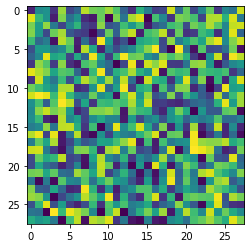

In [3]:
import cv2
import import_ipynb
import utils
import explainers
import colored_mnist

import numpy as np
import random as rd
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
import tensorflow.keras as keras
import matplotlib.pyplot as plt

In [4]:
## Load model and data
(train_images, train_colors, train_numbers, train_mixed), (test_images, test_colors, test_numbers, test_mixed) = colored_mnist.load_data(8000)
model = keras.models.load_model('saved_models/rule_biased')
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           multiple                  1792      
                                                                 
 max_pooling2d_4 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           multiple                  36928     
                                                                 
 max_pooling2d_5 (MaxPooling  multiple                 0         
 2D)                                                             
                

In [5]:
def adversarial_tests():
  pass
  # # red_image = np.random.rand(1,28,28,3)
  # # red_image[..., 1] = red_image[..., 2] = 0
  # # plt.imshow(np.squeeze(red_image))
  # # plt.axis('off')
  # # plt.show()

  # # model.predict(red_image)

  # color_im = np.zeros((1,28,28,3))
  # color_im[0, 0, 0, 1] = 1
  # color_im[0, 0, 1:3, 2] = 1
  # # color_im[0, 5:12, 14:24, 2] = 1
  # # color_im[0, 13:24, 3:14, 2] = 1
  # plt.imshow(np.squeeze(color_im))
  # plt.show()
  # plt.imshow(np.squeeze(color_im[..., 1]), cmap='gray')
  # plt.colorbar()
  # plt.show()

  # print('>> Color')
  # color_model.predict(color_im)
  # # print('>> Shape')
  # # shape_model.predict(color_im)
  # # print('>> Normal')
  # # model.predict(color_im)

  # ## Grad-CAM+SHAP pour voir si ca s'allume autour ou au niveau du chiffre

  # # plt.imshow(np.squeeze(train_images[0]))
  # # plt.axis('off')
  # # plt.show()

  # # new_im = np.zeros((1,28,28,3))
  # # new_im[..., 2] = (1 - train_images[0, ..., 0])
  # # new_im[..., 1] = train_images[0, ..., 0]
  # # plt.imshow(np.squeeze(new_im)[..., 2], cmap='gray')
  # # plt.colorbar()
  # # plt.show()

  # # model.predict(new_im)

In [6]:
## CONFUSIONS
ims, labels = test_images, test_mixed
labs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'r', 'g', 'b']

n = 200
wrong_list = []
test_ims = ims[:n]
preds = model.predict(test_ims)
for i in range(test_ims.shape[0]):
  pred_max = max(preds[i]) # preds and ground are categorical, we must extract the number corresponding to the max value in the array.
  ground_max = max(labels[i])
  pred_value = list(preds[i]).index(pred_max)
  ground_value = list(labels[i]).index(ground_max)

  if pred_value != ground_value:
    print('predicted value: ', labs[pred_value], '  ground truth: ', labs[ground_value], ' <<')
    wrong_list.append((i, pred_value))
  else:
    print('predicted value: ', labs[pred_value] , '  ground truth: ', labs[ground_value])

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


predicted value:  r   ground truth:  r
predicted value:  2   ground truth:  2
predicted value:  1   ground truth:  1
predicted value:  0   ground truth:  0
predicted value:  r   ground truth:  r
predicted value:  1   ground truth:  1
predicted value:  4   ground truth:  4
predicted value:  9   ground truth:  9
predicted value:  r   ground truth:  r
predicted value:  r   ground truth:  r
predicted value:  0   ground truth:  0
predicted value:  r   ground truth:  r
predicted value:  r   ground truth:  r
predicted value:  0   ground truth:  0
predicted value:  r   ground truth:  r
predicted value:  5   ground truth:  5
predicted value:  9   ground truth:  9
predicted value:  r   ground truth:  r
predicted value:  r   ground truth:  r
predicted value:  4   ground truth:  4
predicted value:  7   ground truth:  9  <<
predicted value:  r   ground truth:  r
predicted value:  6   ground truth:  6
predicted value:  5   ground truth:  5
predicted value:  4   ground truth:  4
predicted value:  0  

>> Wrongly classified :  3 / 200


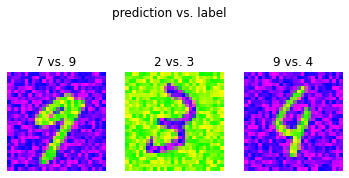

In [7]:
c, plots = 1, 1
print('>> Wrongly classified : ', len(wrong_list), '/', test_ims.shape[0])
plt.suptitle('prediction vs. label', y=0.9)
labs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'red', 'green', 'blue']
for (i, j) in wrong_list:
  ground_truth = list(test_numbers[i])
  max_val = max(ground_truth)
  true_label = ground_truth.index(max_val)
  pred_label = labs[j]

  if plots and wrong_list:
    plt.subplot(1, len(wrong_list), c)
    plt.title('{} vs. {}'.format(pred_label, true_label))
    plt.imshow(test_ims[i])
    plt.axis('off')
  c += 1

In [11]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           multiple                  1792      
                                                                 
 max_pooling2d_4 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           multiple                  36928     
                                                                 
 max_pooling2d_5 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         multiple                  0         
                                                                 
 dense_2 (Dense)             multiple                 

loss :  0.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
1
2
3
4
5
6
7
8
9
10
11
computing shapley values


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


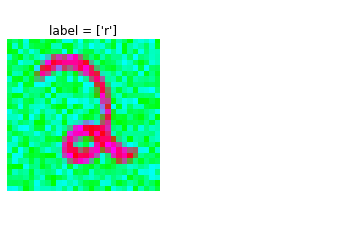

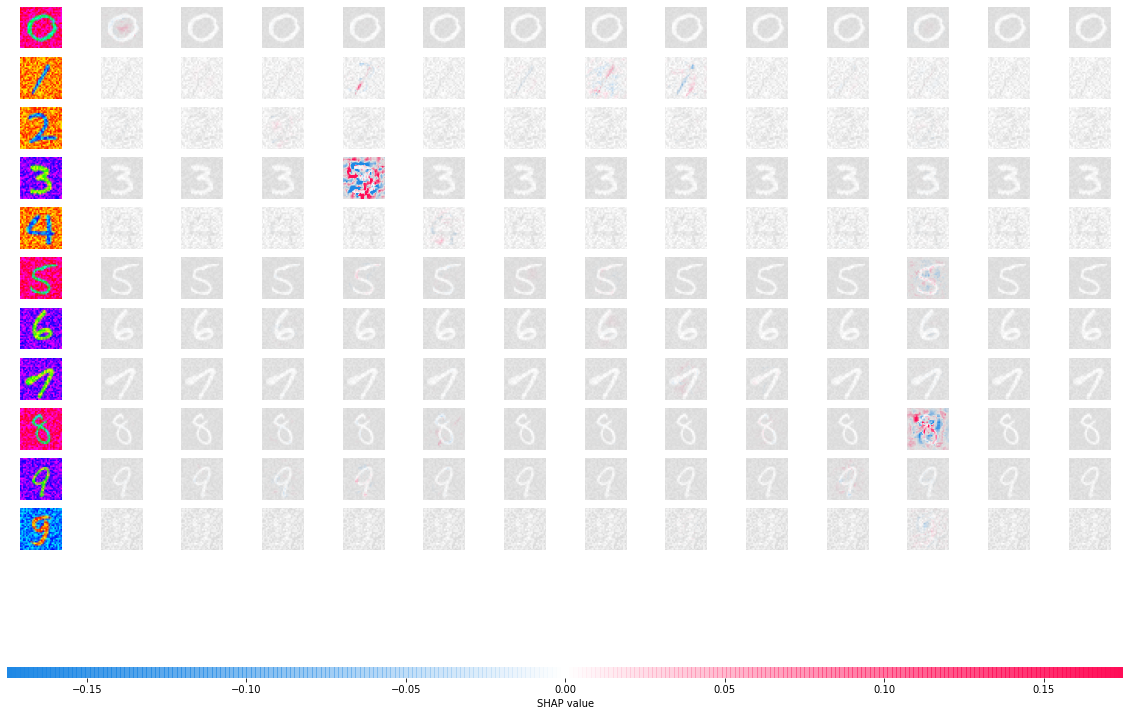

In [14]:
## POST-ANALYSIS
# if wrong_list: # THIS IS DEPRECATED
#   rgb_confusion = np.zeros((3,))
#   for (i, j) in wrong_list: # i : index of wrongly classified image in the test dataset, # j : predicted label of that image.
#     im = test_ims[i]
#     for k in range(3):
#       if im[..., k].any():
#         rgb_confusion[k] += 1

#   rgb_confusion /= len(wrong_list)
#   pie_labels = ['red', 'green', 'blue']
#   plt.pie(rgb_confusion, labels = pie_labels, colors = pie_labels, autopct='%1.1f%%')
#   plt.title('is misclassification linked to color?')
#   plt.show()
explainer = 'shap'

if __name__ == '__main__': # works great
  idx = np.random.randint(0, 2000)
  test_img = test_images[idx]
  test_lab = test_mixed[idx]

  plt.subplot(1, 2, 1)
  plt.title('label = {}'.format(str(utils.uncategoric(test_lab)[0])))
  plt.imshow(test_img)
  plt.axis('off')

  print('loss : ', model.evaluate(test_img[np.newaxis], test_lab[np.newaxis], verbose=0)[0])
  plt.subplot(1, 2, 2)
  plt.axis('off')
  if explainer == 'cam':
    heatmap = explainers.gradcam(model, 'conv2d_4', test_img[np.newaxis])

    plt.imshow(heatmap, cmap='hot')
    plt.title('gradcam')
    plt.show()

  elif explainer == 'rise': # doesn't work very well
    num = 500
    proba = 3/4
    idx = np.random.randint(0, 2000)
    heatmap = explainers.rise(model, test_img, test_lab, num, proba)

    plt.imshow(heatmap, cmap='hot')
    plt.title('rise')
    plt.show()
    
  elif explainer == 'shap':
    tf.compat.v1.disable_v2_behavior()
    vals, imgs = explainers.shap(model, test_images, test_mixed, 100, 11)

  else:
    pass

In [9]:
# ## REPRESENTATIONAL SIMILARITY ANALYSIS
# from keras.models import Model

# models = [color_model, shape_model, model]
# model_names = ['Color-biased model', 'Shape-biased model', 'Rule-biased model']
# im = train_images[0]
# if im.ndim < 4:
#   im = np.expand_dims(im, axis=0)

# f_map = [[],[],[]]
# for (n, model) in enumerate(models):
#   print(model_names[n])
#   for i in range(len(model.layers)):
#     if 'conv' not in model.layers[i].name:
#       continue
#     model2 = Model(inputs=model.inputs, outputs=model.layers[i].output)

#     kernels, biases = model.layers[i].get_weights()
#     k_min, k_max = kernels.min(), kernels.max()
#     kernels = (kernels - k_min) / (k_max - k_min)
#     feature_map = model2.predict(im)

#     # f_map = np.squeeze(feature_map[..., 0])
#     # kernel = np.squeeze(kernels[..., 0, 0]) # Ce zéro est suspect, on ne sait pas si ce feature map vient forcément du 1er input du convolutional layer d'avant.

#     # print(model.layers[i].name, kernels.shape)
#     # plt.figure(figsize=(20,5))
#     # plt.subplot(131)
#     # plt.imshow(np.squeeze(im), aspect='auto')
#     # plt.colorbar()
#     # plt.subplot(132)
#     # plt.imshow(kernel, aspect='auto')
#     # plt.colorbar()
#     # plt.subplot(133)
#     # plt.imshow(f_map, aspect='auto')
#     # plt.colorbar()
#     # plt.show()
#     # Visualize all feature maps and corresponding filters.
#     num_maps = feature_map.shape[-1]
#     rows = int(np.floor(np.sqrt(num_maps)))
#     idx = 1
#     # plt.figure(figsize=(20, 10))
#     print(model.layers[i].name, kernels.shape)
#     for j in range(0, num_maps, 8):
#       # print(num_maps, idx, rows*2*rows)
#       f_map[n].append(np.squeeze(feature_map[..., j]))
#       kernel = np.squeeze(kernels[..., 0, j]) # Ce zéro est suspect : revoir les shape des kernels.

#       if n == 2:
#         print(np.array(f_map).shape)
#         print('color_bias : ', np.corrcoef(f_map[0][-1], f_map[2][-1]))
#         print('shape_bias : ', np.corrcoef(f_map[1][-1], f_map[2][-1]))
#       # plt.subplot(2, 8, idx)
#       # plt.imshow(kernel, aspect='auto')
#       # plt.subplot(2, 8, idx + 1)
#       # plt.imshow(f_map, aspect='auto')

#       idx += 2
#     # plt.show()
#   pass # use feature map analysis code developed last week